## Test Experiments

In [1]:
from utils.utils import *
import optuna
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
from experiments.experiments_gkan import ExperimentsGKAN
from experiments.experiments_mpnn import ExperimentsMPNN

storage = JournalStorage(JournalFileBackend("optuna_journal_storage.log"))

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
config = load_config("./configs/config_ic1/config_population_mpnn.yml")
exp = ExperimentsMPNN(
    config=config,
    n_trials=1,
    study_name='test-pop',
    process_id=0,
)

In [3]:
print(len(exp.training_set))

45


In [ ]:
exp.epochs = 1
exp.run()

[I 2025-05-16 14:52:24,794] Using an existing study with name 'model-population-mpnn-test-pop' instead of creating a new one.
/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


Trial 1: num params: 3442


## Symb Reg

### Utils


In [2]:
from models.utils.MPNN import MPNN
from models.baseline.MPNN_ODE import MPNN_ODE
from train_and_eval import eval_model
from datasets.SyntheticData import SyntheticData
from sympy import symbols, sin, summation, simplify
import networkx as nx
from torch_geometric.utils import from_networkx
from utils.utils import integrate
from torch_geometric.data import Data
from experiments.experiments_mpnn import activations
from models.utils.MLP import MLP

In [8]:
def get_model(g, h, message_passing=True, include_time=False, atol=1e-5, rtol=1e-3, integration_method = 'scipy_solver'):
    conv = MPNN(
        g_net = g,
        h_net = h, 
        message_passing=message_passing,
        include_time=include_time
    )
    
    symb = MPNN_ODE(
        conv=conv,
        model_path="./saved_models_optuna/tmp_symb",
        adjoint=True,
        integration_method=integration_method,
        atol=atol,
        rtol=rtol
    )
    
    return symb


def get_symb_test_error(g_symb, h_symb, test_set, message_passing=False, include_time=False, atol=1e-5, rtol=1e-3, scaler = None, inverse_scale=False, method='scipy_solver'):
    
    # total_len = len(dataset)
    # test_set = dataset[int(0.9*total_len):]
    
    symb = get_model(
        g=g_symb,
        h=h_symb,
        message_passing=message_passing,
        include_time=include_time,
        atol=atol,
        rtol=rtol,
        integration_method=method
    )
    
    test_loss = eval_model(
        model=symb,
        valid_data=test_set,
        criterion=torch.nn.L1Loss(),
        scaler=scaler,
        inverse_scale=inverse_scale
    )
    
    return test_loss


def get_test_set(dynamics, seed=12345, device='cuda', input_range = (0, 1), **integration_kwargs):
    graph = nx.barabasi_albert_graph(100, 3, seed=seed)
    edge_index = from_networkx(graph).edge_index
    edge_index = edge_index.to(torch.device(device))
    rng = np.random.default_rng(seed=seed)
    
    data, t = integrate(
        input_range=input_range,
        t_span = [0, 1],
        t_eval_steps=300,
        dynamics=dynamics,
        device=device,
        graph=graph,
        rng = rng,
        **integration_kwargs
    )
    
    snapshot = Data(
        x = data[0].unsqueeze(0),
        y = data[1:],
        edge_index=edge_index,
        edge_attr=None,
        t_span = t
    )
    
    return [snapshot]


def build_model_from_file(best_params_file, best_state_path, message_passing, include_time, method='midpoint', adjoint=False):
    with open(best_params_file, 'r') as f:
        best_hyperparams = json.load(f)
    
    in_dim = 1
    
    hidden_layers = [best_hyperparams["hidden_dims_g_net"] for _ in range(best_hyperparams["n_hidden_layers_g_net"])]
    hidden_layers = [2*in_dim] + hidden_layers + [in_dim]    
    # g_net
    g_net = MLP(
        hidden_layers=hidden_layers,
        af = activations[best_hyperparams['af_g_net']],
        dropout_rate=best_hyperparams['drop_p_g_net'],
    )
    
    time_dim = 1 if include_time else 0
    in_dim_h = 2 if message_passing else 1
    in_dim_h += time_dim
    hidden_layers = [best_hyperparams["hidden_dims_h_net"] for _ in range(best_hyperparams["n_hidden_layers_h_net"])]
    hidden_layers = [in_dim_h] + hidden_layers + [in_dim] 
    
    
    # h_net
    h_net = MLP(
        hidden_layers=hidden_layers,
        af = activations[best_hyperparams['af_h_net']],
        dropout_rate=best_hyperparams['drop_p_h_net'],
    )
    
    mpnn = MPNN(
        h_net=h_net,
        g_net=g_net,
        message_passing=message_passing,
        include_time=include_time
    )
    
    model = MPNN_ODE(
        conv=mpnn,
        model_path='./saved_models_optuna/tmp',
        integration_method=method,
        adjoint=adjoint
    )
    
    model = model.to(torch.device('cuda'))
    model.load_state_dict(torch.load(best_state_path, weights_only=False))
    
    return model


def plot_predictions(y_true, y_pred, node_index = 0):
    plt.figure(figsize=(16, 8))
    plt.plot(y_true[:, node_index, :], label='y_true', marker='o')
    plt.plot(y_pred[:, node_index, :], label='y_pred', marker='o')
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.title(f'y_true vs y_pred for Node {node_index}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### LB Losses

#### Kuramoto

In [10]:
kur_config = load_config("./configs/config_ic1/config_kuramoto.yml")

KUR = get_test_set(
    dynamics=kur_config['name'],
    seed = 12345,
    device=kur_config['device'],
    input_range=kur_config['input_range'],
    **kur_config['integration_kwargs']    
)

g_symb = lambda x: torch.sin(x[:, 1] - x[:, 0]).unsqueeze(-1)
h_symb = lambda x: 2.0 + 0.5 * x[:, 1].unsqueeze(-1)

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=KUR,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Kuramoto: {test_loss}")


/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


Kuramoto: 7.65262811910361e-05


#### Epidemics

In [12]:
epid_config = load_config("./configs/config_ic1/config_epidemics.yml")

EPID = get_test_set(
    dynamics=epid_config['name'],
    seed = 12345,
    device=epid_config['device'],
    input_range=epid_config['input_range'],
    **epid_config['integration_kwargs']    
)

g_symb = lambda x: 0.5*x[:, 1].unsqueeze(-1) * (1 - x[:, 0].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(1) - 0.5 * x[:, 0].unsqueeze(-1)

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=EPID,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Epidemics: {test_loss}")


Epidemics: 1.2386286471155472e-05


#### Neuronal

In [ ]:
neur_config = load_config("./configs/config_ic1/config_neuronal.yml")

NEUR = get_test_set(
    dynamics=neur_config['name'],
    seed = 12345,
    device=neur_config['device'],
    input_range=neur_config['input_range'],
    **neur_config['integration_kwargs']    
)

g_symb = lambda x: 0.3*torch.tanh(x[:, 1].unsqueeze(-1))
h_symb = lambda x: -0.5 * x[:, 0].unsqueeze(-1) + 0.8*torch.tanh(x[:, 0].unsqueeze(-1)) + x[:, 1].unsqueeze(-1) 

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=NEUR,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Neuronal: {test_loss}")

#### Biochemical

In [18]:
bio_config = load_config("./configs/config_ic1/config_biochemical.yml")

BIO = get_test_set(
    dynamics=bio_config['name'],
    seed = 12345,
    device=bio_config['device'],
    input_range=bio_config['input_range'],
    **bio_config['integration_kwargs']    
)

g_symb = lambda x: (-0.5*x[:, 1] * x[:, 0]).unsqueeze(-1)
h_symb = lambda x: (1.0 - 0.5 * x[:, 0]).unsqueeze(-1)  + x[:, 1].unsqueeze(-1) 

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=BIO,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Biochemical: {test_loss}")

/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


Biochemical: 5.4492534218297806e-06


#### Population

In [29]:
pop_config = load_config("./configs/config_ic1/config_population.yml")

POP = get_test_set(
    dynamics=pop_config['name'],
    seed = 12345,
    device=pop_config['device'],
    input_range=pop_config['input_range'],
    **pop_config['integration_kwargs']    
)

g_symb = lambda x: 0.2*torch.square(x[:, 1].unsqueeze(-1))
h_symb = lambda x: -0.5 * torch.square(x[:, 0].unsqueeze(-1)) + x[:, 1].unsqueeze(1) 

test_loss = get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=POP,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)

print(f"Population: {test_loss}")


/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


Population: 1.6145211702678353e-05


### Kuramoto MPNN

#### IC=1

In [3]:
model_path_mpnn = './saved_models_optuna/model-kuramoto-mpnn/kuramoto_mpnn_ic1_s5/2/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [4]:
mpnn_symb

\sum_{j}( -0.48788536*sin(x_i - x_j)) + tanh(exp(x_i)) + 1.0103389

#### IC=3

In [2]:
model_path_mpnn = './saved_models_optuna/model-kuramoto-mpnn/kuramoto-mpnn_3/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=150
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [3]:
mpnn_symb

\sum_{j}( -0.51732075*sin(x_i - x_j)) - 0.0023250817*x_i + 2.0001836

In [11]:
g_symb = lambda x: torch.sin(x[:, 0] - x[:, 1]).unsqueeze(-1)
h_symb = lambda x: 2.0001836 - 0.51732075 * x[:, 1].unsqueeze(-1) - 0.0023250817 * x[:, 0].unsqueeze(-1)


print(get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=KUR,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3,
    method="scipy_solver"
))

0.010858498513698578


#### IC=5

### Epidemics MPNN

#### IC=1

In [5]:
model_path_mpnn = './saved_models_optuna/model-epidemics-mpnn/epidemics_mpnn_ic1_s5/1/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [6]:
mpnn_symb

\sum_{j}( x_j*(0.49503535 - 0.4945444*x_i)) - 0.6940843*tanh(x_i) + 0.064974605609914

#### IC=3

In [2]:
model_path_mpnn = './saved_models_optuna/model-epidemics-mpnn/epidemics-mpnn_2/2/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=150
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [3]:
mpnn_symb

\sum_{j}( x_j*(0.50071 - 0.5002975*x_i)) - 0.500388952332648*x_i

In [13]:
g_symb = lambda x: x[:, 1].unsqueeze(-1) * (0.50071 - 0.5002975 * x[:, 0]).unsqueeze(-1)
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.500388952332648 * x[:, 0].unsqueeze(-1)

print(get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=EPID,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
))

0.0005119662382639945


#### IC=5

### Neuronal MPNN

#### IC=1

In [14]:
model_path_mpnn = './saved_models_optuna/model-neuronal-mpnn/neuronal_mpnn_ic1_s5/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [15]:
mpnn_symb

\sum_{j}( 0.29048842*tanh(x_j)) - log(x_i + 1) + tanh(x_i)

#### IC=3

#### IC=5

### Biochemical MPNN

#### IC=3

In [16]:
model_path_mpnn = './saved_models_optuna/model-biochemical-mpnn/biochemical_mpnn_ic3_s5/0/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [17]:
mpnn_symb

\sum_{j}( -0.49841055*x_i*x_j) + log(2.6208985 - x_i)

In [19]:
g_symb = lambda x: - 0.49841055 * x[:, 0].unsqueeze(-1) * x[:,1].unsqueeze(-1)
h_symb = lambda x: x[:, 1].unsqueeze(-1) + torch.log(2.6208985 - x[:, 0].unsqueeze(-1))

print(
    get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=BIO,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)
)

/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


0.0013899521436542273


#### IC=1

In [20]:
model_path_mpnn = './saved_models_optuna/model-biochemical-mpnn/biochemical_mpnn_ic1_s5/1/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [21]:
mpnn_symb

\sum_{j}( -0.50093955*x_i*x_j) + log(2.6312691 - x_i)

In [22]:
g_symb = lambda x: - 0.50093955 * x[:, 0].unsqueeze(-1) * x[:,1].unsqueeze(-1)
h_symb = lambda x: x[:, 1].unsqueeze(-1) + torch.log(2.6312691 - x[:, 0].unsqueeze(-1))

print(
    get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=BIO,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)
)

/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


0.0016501377103850245


#### IC=5

In [23]:
model_path_mpnn = './saved_models_optuna/model-biochemical-mpnn/biochemical_mpnn_ic5_s5/2/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [24]:
mpnn_symb

\sum_{j}( -0.5005229*x_i*x_j) - sin(tanh(x_i) - 1.3103138)

In [26]:
g_symb = lambda x: - 0.5005229 * x[:, 0].unsqueeze(-1) * x[:,1].unsqueeze(-1)
h_symb = lambda x: x[:, 1].unsqueeze(-1) - torch.sin(torch.tanh(x[:, 0].unsqueeze(-1)) - 1.3103138)

print(
    get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=BIO,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)
)

0.0005943095311522484


### Population MPNN

#### IC=1

In [27]:
model_path_mpnn = "./saved_models_optuna/model-population-mpnn/population_mpnn_ic1_s5/0/mpnn"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [28]:
mpnn_symb

\sum_{j}( 0.147783*x_j**2) - 0.4844213*x_i

In [33]:
g_symb = lambda x: 0.147783 * torch.square(x[:, 1].unsqueeze(-1))
h_symb = lambda x: x[:, 1].unsqueeze(-1) - 0.4844213 * x[:, 0].unsqueeze(-1)

print(
    get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=POP,
    message_passing=True,
    include_time=False,
    atol=1e-5,
    rtol=1e-3
)
)

/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


0.1846676766872406


#### IC=3

In [34]:
model_path_mpnn = "./saved_models_optuna/model-population-mpnn/population_mpnn_ic3_s5/0/mpnn"

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [35]:
mpnn_symb

\sum_{j}( 0.172337832074246*x_j**2) - log(log(x_i**3 + 1) + 1)

#### IC=5

## Real Epid data

In [2]:
from models.utils.MPNN import MPNN
from models.kan.KAN import KAN
from models.GKAN_ODE import GKAN_ODE
from experiments.experiments_mpnn import activations
from models.utils.MLP import MLP


def build_model_from_file(best_params_file, best_state_path, message_passing, include_time, method='midpoint', adjoint=False):
    with open(best_params_file, 'r') as f:
        best_hyperparams = json.load(f)
    
    in_dim = 1
    
    hidden_layers = [best_hyperparams["hidden_dims_g_net"] for _ in range(best_hyperparams["n_hidden_layers_g_net"])]
    hidden_layers = [2*in_dim] + hidden_layers + [in_dim]    
    # g_net
    g_net = MLP(
        hidden_layers=hidden_layers,
        af = activations[best_hyperparams['af_g_net']],
        dropout_rate=best_hyperparams['drop_p_g_net'],
    )
    
    time_dim = 1 if include_time else 0
    in_dim_h = 2 if message_passing else 1
    in_dim_h += time_dim
    hidden_layers = [best_hyperparams["hidden_dims_h_net"] for _ in range(best_hyperparams["n_hidden_layers_h_net"])]
    hidden_layers = [in_dim_h] + hidden_layers + [in_dim] 
    
    
    # h_net
    h_net = MLP(
        hidden_layers=hidden_layers,
        af = activations[best_hyperparams['af_h_net']],
        dropout_rate=best_hyperparams['drop_p_h_net'],
    )
    
    mpnn = MPNN(
        h_net=h_net,
        g_net=g_net,
        message_passing=message_passing,
        include_time=include_time
    )
    
    model = MPNN_ODE(
        conv=mpnn,
        model_path='./saved_models_optuna/tmp',
        integration_method=method,
        adjoint=adjoint
    )
    
    model = model.to(torch.device('cuda'))
    model.load_state_dict(torch.load(best_state_path, weights_only=False))
    
    return model

In [49]:
best_model = build_model_from_file(
    best_params_file="./saved_models_optuna/model-real-epidemics-mpnn/real_epid_mpnn/0/best_params.json",
    best_state_path = "./saved_models_optuna/model-real-epidemics-mpnn/real_epid_mpnn/0/mpnn/state_dict.pth",
    message_passing=False,
    include_time=False,
    method="dopri5",
    adjoint=True
)

In [14]:
config = load_config("./configs/config_real_epidemics_mpnn.yml")

exp = ExperimentsMPNN(
    config=config,
    n_trials=1,
    study_name='test-baseline',
    process_id=0,
)

scaler = exp.pre_processing(exp.training_set)
exp.scaler = scaler

exp.post_processing(best_model=best_model)

In [4]:
model_path_mpnn = './saved_models_optuna/model-real-epidemics-mpnn/real_epid_mpnn/5/mpnn'

pysr_model = lambda : get_pysr_model(
    model_selection="score",
    n_iterations=200
)

mpnn_symb = fit_mpnn(
    model_path=model_path_mpnn,
    pysr_model=pysr_model,
    sample_size=9000,
    message_passing=False
)

/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/ricca/miniconda3/envs/myenv/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [5]:
mpnn_symb

\sum_{j}( x_i + 1.087914) - 3.57816536226437*tanh(log(Abs(x_i)))

In [50]:
from tsl.data.preprocessing.scalers import MinMaxScaler, StandardScaler

def pre_processing(training_set, out_range = (-1, 1), device='cuda', min_max = True):
    all_train_x = torch.cat([data.x.view(-1) for data in training_set], dim=0)  
    if min_max:
        scaler = MinMaxScaler(out_range=out_range)
    else:
        scaler = StandardScaler()
    scaler.fit(all_train_x.detach().cpu())

    scaler.scale = scaler.scale.to(torch.device(device))
    scaler.bias = scaler.bias.to(torch.device(device))

    return scaler

In [52]:
from datasets.RealEpidemics import RealEpidemics

g_symb = lambda x: x[:, 0].unsqueeze(-1) + 1.2868367
h_symb = lambda x: x[:, 1].unsqueeze(-1) -torch.square(x[:, 0]).unsqueeze(-1) + 1.2340752

config = load_config("./configs/config_real_epidemics_mpnn.yml")

exp = ExperimentsMPNN(
    config=config,
    n_trials=1,
    study_name='test-baseline',
    process_id=0,
)

scaler = pre_processing(exp.training_set, min_max=True, out_range=(-1, 1))

print(get_symb_test_error(
    g_symb=g_symb,
    h_symb=h_symb,
    test_set=exp.test_set,
    message_passing=True,
    include_time=False,
    scaler=scaler,
    inverse_scale=True
))

285.5475158691406


### Plots

In [35]:
import matplotlib.pyplot as plt
import json

In [36]:
def plot_predictions(snapshot, t_end, ode_model, y_true, node_idx = 0, scaler=None):
    ode_model.eval()
    T = y_true.shape[0] + 1
    t_start = snapshot.t_span[0]
    eval_time = torch.linspace(t_start.item(), t_end.item(), T, device=t_start.device)
    snapshot.t_span = eval_time
    
    if scaler is not None:
        snapshot.x = scaler.transform(snapshot.x)
    
    y_pred = ode_model(snapshot) # (eval_time-1, N, 1)
    
    if scaler is not None:
        y_pred = scaler.inverse_transform(y_pred)  
    
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    
    T = y_true.shape[0]
    time = time = np.arange(T)
    
    plt.figure(figsize=(10, 5))
    plt.plot(time, y_true[:, node_idx, :], label='y_true', linestyle='-', marker='o')
    plt.plot(time, y_pred[:, node_idx, :], label='y_pred', linestyle='--', marker='x')
    plt.title(f"Comparison for N_idx = {node_idx}")
    plt.xlabel("Time Step (T)")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

In [37]:
start_x = exp.training_set[0]
t_end = exp.test_set[-1].t_span[-1]
y_true = exp.training_set.raw_data_sampled
with open("./data/Real-Epidemics/countries_dict.json", 'r') as f:
    countries_df = json.load(f)

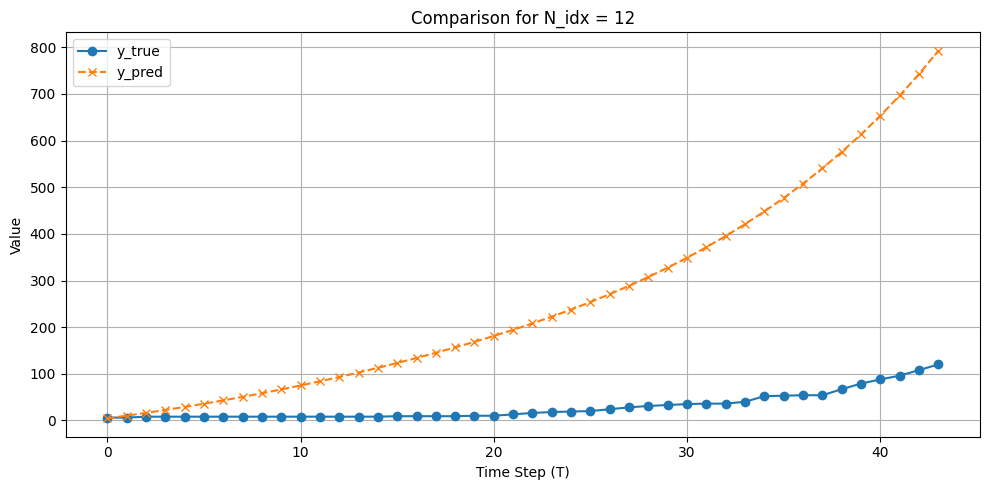

In [40]:
# base_expr = get_model(
#     g=g_symb,
#     h=h_symb,
# )


plot_predictions(
    snapshot=start_x,
    t_end = t_end,
    ode_model=best_model,
    y_true=y_true[0, 1:, :, :],
    node_idx=countries_df["Brazil"],
    scaler=scaler
)